# Contour plots of linear static analysis results for plates

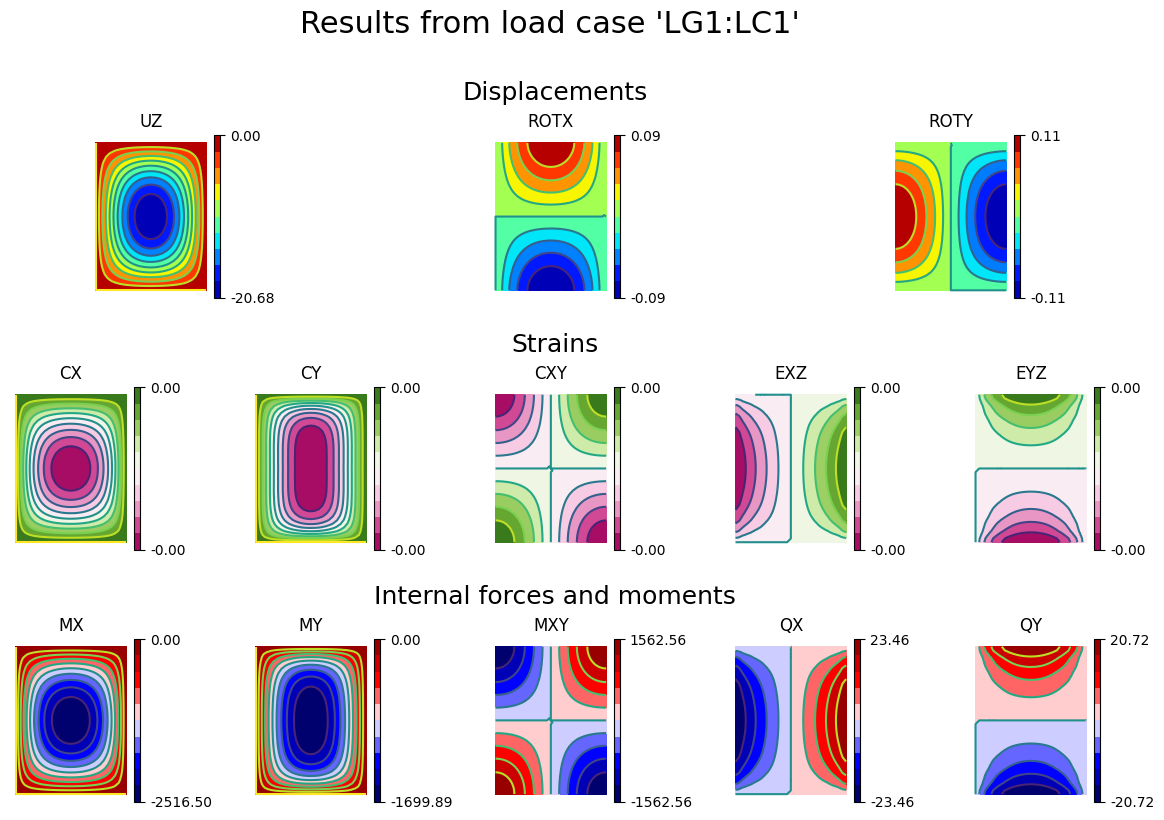

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.mesh.grid import grid
from sigmaepsilon.mesh import triangulate
from sigmaepsilon.mesh.utils.topology.tr import Q4_to_T3
from sigmaepsilon.mesh.plotting import triplot_mpl_data
from sigmaepsilon.solid.material import MindlinPlateSection as Section
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

from sigmaepsilon.solid.fourier import (
    NavierPlate,
    LoadGroup,
    PointLoad,
    RectangleLoad,
)

# geometry
length_X, length_Y = (600.0, 800.0)
thickness = 25.0

# material properties
young_modulus = 2890.0
poisson_ratio = 0.2
yield_strength = 2.0

# solution parameters
number_of_modes_X = 20
number_of_modes_Y = 20

# setting up hooke's law
hooke = elastic_stiffness_matrix(E=young_modulus, NU=poisson_ratio)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)
failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=yield_strength)
material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)
section = Section(
    layers=[
        Section.Layer(material=material, thickness=thickness),
    ]
)
ABDS_matrix = section.elastic_stiffness_matrix()
bending_stiffness, shear_stiffness = (
    np.ascontiguousarray(ABDS_matrix[:3, :3]),
    np.ascontiguousarray(ABDS_matrix[3:, 3:]),
)

# set up loads
loads = LoadGroup(
    LG1=LoadGroup(
        LC1=RectangleLoad([[0, 0], [length_X, length_Y]], [-0.1, 0, 0]),
        LC2=RectangleLoad(
            [[length_X / 3, length_Y / 2], [length_X / 2, 2 * length_Y / 3]],
            [-1, 0, 0],
        ),
    ),
    LG2=LoadGroup(
        LC3=PointLoad([length_X / 3, length_Y / 2], [-100.0, 0, 0]),
        LC4=PointLoad([2 * length_X / 3, length_Y / 2], [100.0, 0, 0]),
    ),
)
loads.lock()  # freezes the layout to protect agains typos

# set up plate
plate = NavierPlate(
    (length_X, length_Y),
    (number_of_modes_X, number_of_modes_Y),
    D=bending_stiffness,
    S=shear_stiffness,
)

# set up the grid for evaluation points and plotting
nx, ny = (30, 40)
evaluation_points, quads = grid(size=(length_X, length_Y), shape=(nx, ny), eshape="Q4")
evaluation_points, triangles = Q4_to_T3(evaluation_points, quads)
triobj = triangulate(points=evaluation_points[:, :2], triangles=triangles)[-1]

# calculate results
results = plate.linear_static_analysis(loads, evaluation_points)

# ------------------------------------------ plotting ------------------------------------------

plt.style.use("default")

fig = plt.figure(layout='constrained', figsize=(12, 8))
fig.suptitle("Results from load case 'LG1:LC1' \n", fontsize=22)
subfigs = fig.subfigures(3, 1, hspace=0.1)

# plotting the displacements
axs_top = subfigs[0].subplots(1, 3, sharey=True)
subfigs[0].set_facecolor("white")
subfigs[0].suptitle("Displacements", fontsize=18)
for i, key in enumerate(["UZ", "ROTX", "ROTY"]):
    triplot_mpl_data(
        triobj,
        ax=axs_top[i],
        fig=fig,
        title=key,
        data=results["LG1", "LC1"].to_xarray().loc[:, key].values,
        cmap="jet",
        axis="off",
        nlevels=10,
        lw=0
    )

# plotting strains
axs_middle = subfigs[1].subplots(1, 5, sharey=True)
subfigs[1].set_facecolor("white")
subfigs[1].suptitle("Strains", fontsize=18)
for i, key in enumerate(["CX", "CY", "CXY", "EXZ", "EYZ"]):
    triplot_mpl_data(
        triobj,
        ax=axs_middle[i],
        fig=fig,
        title=key,
        data=results["LG1", "LC1"].to_xarray().loc[:, key].values,
        cmap="PiYG",
        axis="off",
        nlevels=10,
        lw=0
    )

# plotting internal forces and moments
axs_bottom = subfigs[2].subplots(1, 5, sharey=True)
subfigs[2].set_facecolor("white")
subfigs[2].suptitle("Internal forces and moments", fontsize=18)
for i, key in enumerate(["MX", "MY", "MXY", "QX", "QY"]):
    triplot_mpl_data(
        triobj,
        ax=axs_bottom[i],
        fig=fig,
        title=key,
        data=results["LG1", "LC1"].to_xarray().loc[:, key].values,
        cmap="seismic",
        axis="off",
        nlevels=10,
        lw=0
    )